## Gilled Mushrooms from Agaricus and Lepiota Family - LinearSVC classification

According to Scikit-learn algorithm cheat sheet, I should start my analysis with Linear SVC (Support Vector Classifier) model, as I have over 50 samples, trying to predict a category (poisonous or etable), have already labeled data and the number of my samples doesn't exceed 100 K examples. In case that won't work, I should be using KNeighbors Clasisfier and in case that has problems, Ensemble Classifiers and SVC. In the previous file I tuned in Linear SVC and Decsision Tree. I will use another splitting technic to verify my results and create an application that will allow to choose different features and get prediction of mushroom classification. 

In [1]:
import re, csv, os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sklearn
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.svm import SVC

from sklearn.metrics import  classification_report, accuracy_score, confusion_matrix
%matplotlib inline

In [2]:
import itertools
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return

In [3]:
df = pd.read_csv('/Users/dariaulybina/Desktop/georgetown/ml_practice/data/data.csv')
df = df.drop(df.columns[[0]], axis=1)  
df.head()

,classif,cap_shape,cap_surface,cap_colour,bruises,odor,gill_attach,gill_space,gill_size,gill_color,...,stalk_surf_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,Poisonous,x,s,Brown,Bruises,Pungent,f,Close,Narrow,Black,...,s,White,White,p,w,o,Pendant,Black,Scattered,Urban
1,Etable,x,s,Yellow,Bruises,Almond,f,Close,Broad,Black,...,s,White,White,p,w,o,Pendant,Brown,Numerous,Grasses
2,Etable,b,s,White,Bruises,Anise,f,Close,Broad,Brown,...,s,White,White,p,w,o,Pendant,Brown,Numerous,Meadows
3,Poisonous,x,y,White,Bruises,Pungent,f,Close,Narrow,Brown,...,s,White,White,p,w,o,Pendant,Black,Scattered,Urban
4,Etable,x,s,Gray,No,None,f,Crowded,Broad,Black,...,s,White,White,p,w,o,Evanescent,Brown,Abundant,Grasses


In [4]:
df = df[['classif','odor','habitat', 'cap_colour']]
df.head()

,classif,odor,habitat,cap_colour
0,Poisonous,Pungent,Urban,Brown
1,Etable,Almond,Grasses,Yellow
2,Etable,Anise,Meadows,White
3,Poisonous,Pungent,Urban,White
4,Etable,None,Grasses,Gray


In [5]:
#Split randomly and store separetly the main file by two - training and testing - just for practice purposes
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]
print(len(train))
print(len(test))
train.to_csv('/Users/dariaulybina/Desktop/georgetown/ml_practice/data/m_train.csv')
test.to_csv('/Users/dariaulybina/Desktop/georgetown/ml_practice/data/m_test.csv')

6514
1610


In [6]:
names = ['classif','odor', 'habitat', 'cap_colour']
data = pd.read_csv('data/m_train.csv', names=names, skiprows=1)
data.head()

,classif,odor,habitat,cap_colour
0,Poisonous,Pungent,Urban,Brown
1,Etable,Almond,Grasses,Yellow
3,Poisonous,Pungent,Urban,White
4,Etable,None,Grasses,Gray
5,Etable,Almond,Grasses,Yellow


In [7]:
import json

meta = {
    'target_names': list(data.classif.unique()),
    'feature_names': list(data.columns),
    'categorical_features': {
        column: list(data[column].unique())
        for column in data.columns
        if data[column].dtype == 'object'
    },
}

with open('/Users/dariaulybina/Desktop/georgetown/ml_practice/data/meta.json', 'w') as f:
    json.dump(meta, f)

In [9]:
import os
import json

from sklearn.datasets.base import Bunch

def load_data(root='data'):
    # Load the meta data from the file 
    with open(os.path.join(root, 'meta.json'), 'r') as f:
        meta = json.load(f) 
    
    names = meta['feature_names']
    print(names)
    print(meta['target_names'])
    # Load the data and delete first bad column
    train = pd.read_csv(os.path.join(root, 'm_train.csv'), names=names, skiprows=1)
    test  = pd.read_csv(os.path.join(root, 'm_test.csv'), names=names, skiprows=1)
    
    # Remove the target from the categorical features 
    meta['categorical_features'].pop('classif')
    
    
    # Return the bunch with the appropriate data chunked apart
    return Bunch(
        data = train[names[1:]], 
        target = train[names[0]], 
        data_test = test[names[1:]], 
        target_test = test[names[0]], 
        target_names = meta['target_names'],
        feature_names = meta['feature_names'], 
        categorical_features = meta['categorical_features']
    )

dataset = load_data()

['classif', 'odor', 'habitat', 'cap_colour']
['Poisonous', 'Etable']


In [10]:
dataset.data.head()

,odor,habitat,cap_colour
0,Pungent,Urban,Brown
1,Almond,Grasses,Yellow
3,Pungent,Urban,White
4,None,Grasses,Gray
5,Almond,Grasses,Yellow


In [11]:
dataset.target.head()

0    Poisonous
1       Etable
3    Poisonous
4       Etable
5       Etable
Name: classif, dtype: object

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
class EncodeCategorical(BaseEstimator, TransformerMixin):
    """
    Encodes a specified list of columns or all columns if None. 
    """
    
    def __init__(self, columns=None):
        self.columns  = [col for col in columns] 
        self.encoders = None
    
    def fit(self, data, target=None):
        """
        Expects a data frame with named columns to encode. 
        """
        # Encode all columns if columns is None
        if self.columns is None:
            self.columns = data.columns 
        
        # Fit a label encoder for each column in the data frame
        self.encoders = {
            column: LabelEncoder().fit(data[column])
            for column in self.columns 
        }
        return self

    def transform(self, data):
        """
        Uses the encoders to transform a data frame. 
        """
        output = data.copy()
        for column, encoder in self.encoders.items():
            output[column] = encoder.transform(data[column])
            
        return output
    
    def inverse_transform(self, data):
        output = X.copy()
        for column, encoder in self.encoders.items():
            output[column] = encoder.inverse_transform(data[column])
            
        return output

In [13]:
encoder = EncodeCategorical(dataset.categorical_features.keys())
data = encoder.fit_transform(dataset.data)
data

,odor,habitat,cap_colour
0,7,4,0
1,0,0,9
3,7,4,8
4,6,0,3
5,0,0,9
6,0,2,8
7,1,2,8
8,7,0,8
10,1,0,9
11,0,2,9


In [14]:
for col, lec in encoder.encoders.items():
    try:
        print(lec.classes_)
    except:
        pass

['Almond' 'Anise' 'Creosote' 'Fishy' 'Foul' 'Musty' 'None' 'Pungent'
 'Spicy']
['Grasses' 'Leaves' 'Meadows' 'Paths' 'Urban' 'Waste' 'Woods']
['Brown' 'Buff' 'Cinnamon' 'Gray' 'Green' 'Pink' 'Purple' 'Red' 'White'
 'Yellow']


In [15]:
data

,odor,habitat,cap_colour
0,7,4,0
1,0,0,9
3,7,4,8
4,6,0,3
5,0,0,9
6,0,2,8
7,1,2,8
8,7,0,8
10,1,0,9
11,0,2,9


In [16]:
print(dataset.data.shape)
print(dataset.target.shape)

(6514, 3)
(6514,)


The shape of the data informs that I have 3 features and 6517 instances of my species in training subset. 

### Linear SVM

I will use GridSearchCV option to idnetify the best hyperparameters of this model that will define my final model form. 

__Comment on results:__ <br>
Optimal penalty parameter in my case: C=1. <br>
The test-mean scores have accuracy of almost 100%. Another option could be to try to minimise Type II error to avoid problems with identifying poisonous species as etable. One could certainly chnage the model or features. However, given my set of features and recommendation on model utilization, I will keep linear SVC with C=1 for my final model estimation. 

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC

# we need to encode our target data as well. 
yencode = LabelEncoder().fit(dataset.target)

# figure out the indices of the categorical columns 
categorical_indexes = [
    list(dataset.data.columns).index(key) for key in dataset.categorical_features.keys()
]

# construct the pipeline 
mushrooms = Pipeline([
    ('encoder',  EncodeCategorical(dataset.categorical_features.keys())),
    ('onehot', OneHotEncoder(categorical_features=categorical_indexes)),
    #('classifier', DecisionTreeClassifier()) #worked 99% with odor, cap color and habitat
    #('classifier', LogisticRegression())
    ('classifier', SVC(kernel='linear', C=1))
    #('classifier', RandomForestClassifier())
    ])

# fit the pipeline 
mushrooms.fit(dataset.data, yencode.transform(dataset.target))

Pipeline(steps=[('encoder', EncodeCategorical(columns=['odor', 'habitat', 'cap_colour'])), ('onehot', OneHotEncoder(categorical_features=[0, 1, 2], dtype=<class 'float'>,
       handle_unknown='error', n_values='auto', sparse=True)), ('classifier', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

             precision    recall  f1-score   support

  Poisonous       0.99      1.00      0.99       855
     Etable       1.00      0.99      0.99       755

avg / total       0.99      0.99      0.99      1610

0.992546583851
[[853   2]
 [ 10 745]]


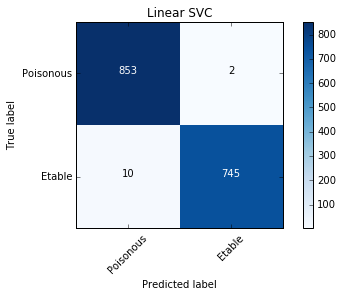

In [19]:
from sklearn.metrics import classification_report 

# encode test targets, and strip traililng '.' 
y_true = yencode.transform([y.rstrip(".") for y in dataset.target_test])

# use the model to get the predicted value
y_pred = mushrooms.predict(dataset.data_test)

# execute classification report 
print(classification_report(y_true, y_pred, target_names=dataset.target_names))

print(accuracy_score(y_true, y_pred))

plot_confusion_matrix(confusion_matrix(y_true, y_pred), classes = dataset.target_names, title = "Linear SVC")


In [20]:
import pickle 

def dump_model(model, path='data', name='classifier.pickle'):
    with open(os.path.join(path, name), 'wb') as f:
        pickle.dump(model, f)
        
dump_model(mushrooms)

### Model Operation
Now I will try to explore the usage of the model. I will first load the pickled model from the previous step (Linear SVC, C=1). Then the choice of inputs corresponding to categories within features will be collected from the command line> The result will return a prediction with the classifier model.

Just to give some direction in terms of choosing different parameters, that the model operator will ask in order to make predictions: <br>
__Cap Colors options:__ 'Brown', 'Yellow', 'White', 'Gray', 'Red', 'Pink', 'Buff', 'Purple', 'Cinnamon', 'Green'<br>
__Habitat options:__ 'Urban', 'Grasses', 'Meadows', 'Woods', 'Paths', 'Waste', 'Leaves'<br>
__Odor options:__ 'Pungent', 'Almond', 'Anise', 'None', 'Foul', 'Creosote', 'Fishy', 'Spicy', 'Musty'<br><br>

I provided some picture with examples of different mushrooms - it is possible to use those as inspiration for a prediction sample. Additionally, there are general rules for poisonous mushrooms identification - we can check if my classifier will obey those rules by adding/deleting some of the features in the beginning of this notebook and re-running the model. <br><br>
__Common Rules:__
<table align="left" cellpadding="0" cellspacing="0" border="0" width = 600px>
<tbody>
<tr> <td><p style="text-align:left; padding-left:20px; padding-right:20px;"> Warts or scales on the cap: off colored "patches". These are the remnants of the universal veil that surrounds the mushroom when it is young.</p></td>
<td valign="right" style="width:100px; height:150px;" colspan="1"><img src="images/xpoisonous-mushroom.jpg" alt="" /></td>
</tr>
<tr><td><p style="text-align:left; padding-left:20px; padding-right:20px;">A parasol or umbrella shaped cap - many amanita caps are shaped in this way - convex like a wide, upside down letter U. Or like an inverted parabola! </p></td><td valign="right" style="width:100px; height:150px;" colspan="1"><img src="images/poisonous-mushrooms.jpg" alt="" /></td></tr>
<tr><td><p style="text-align:left; padding-left:20px; padding-right:20px;">The presence of a ring around the stem or gills that are thin and white. The ring is where the partial veil was attached to the stem before it tore apart as the mushroom grew. The picture shows the white gills of an Amanita and its ring.</p> </td><td valign="right" style="width:100px; height:150px;" colspan="1"><img src="images/xidentify-amanita-mushrooms.jpg" alt="" /></td></tr>
<tr><p>More information about identification of mushrooms is available at  <a href="http://www.mushroom-appreciation.com/identify-poisonous-mushrooms.html#sthash.nEIO6755.dpuf">Mushroom Appreciation website.</a></p></tr></tbody></table>

<p><b>...and more mushrooms (Agaricus and Lepiota families) with characteristcs!</b></p>

<table align="left" cellpadding="0" cellspacing="0" border="0" width = 600px>
<tbody>
<tr>
<td style="text-align:left;" colspan ="1"><p style="text-align:left;  padding-left:20px; padding-right:20px;"><b>Portobello Mushroom</b><br>Cap Color:  pale grey-brown, with broad, flat scales <br>Habitat: waste<br>Odor: Almonds<br> Gills: narrow, crowded, free and initially, pink, then red-brown<br></p></td>
<td valign="right" style="width:170px; height:100px;" colspan="1"><img src="images/portobello.jpg" alt="Portobello" /></td>
</tr>
<tr>
<td style="text-align:right; width:150px" colspan ="1"><p style="text-align:left; padding-left:20px; padding-right:20px;"><b>Field Mushroom</b><br>Cap Color: creamy white <br>Habitat: grass<br>Odor: None<br> Gills: deep pink<br></p></td>
<td valign="right" style="width:170px; height:100px;" colspan="1"><img src="images/agaricus-campestris_field_mushroom.jpg" alt="field" /></td>
</tr>
<tr>
<td style="text-align:right; width:150px" colspan ="1"><p style="text-align:left; padding-left:20px; padding-right:20px;"><b>Yellow-Stainer</b><br>Cap Color: white or whitish <br> Habitat: grass <br> Odor: Foul (ink, phenol or iodine)<br> Gills: grey <br> Stem: bright yellow when cut</p></td>
<td valign="right" style="width:170px; height:100px;" colspan="1"><img src="images/yellow_stainer.jpg" alt="yellow_stainer" /></td>
</tr>
<tr>
<td style="text-align:right; width:150px" colspan ="1"><p style="text-align:left; padding-left:20px; padding-right:20px;"><b>Earthy Powdercap</b><br>Cap Color: from pale ochraceous yellow to reddish brown <br>Habitat: marshy grassland and woodlands<br>Odor: Musty or earthy<br>Gills: adnate or adnexed, crowded, white</p></td>
<td valign="right" style="width:170px; height:100px;" colspan="1"><img src="images/cystoderma-amianthinum.jpg" alt="Earthy_Powdercap" /></td>
</tr>
<td style="text-align:right; width:150px" colspan ="1"><p style="text-align:left; padding-left:20px; padding-right:20px;"><b>Stinking Dapperling</b><br>Cap Color:red-brown scales on a white background<br>Habitat: groups and solitary in mixed woodlands, garden shrubberies<br>Odor: unpleasant rubbery odour<br>Gills: free, crowded, white or cream<br>
</p></td>
<td valign="right" style="width:170px; height:100px;" colspan="1"><img src="images/lepiota-cristata.jpg" alt="lepoita" /></td>
</tr>
</tbody>
</table>

In [21]:
def load_model(path='data/classifier.pickle'):
    with open(path, 'rb') as f:
        return pickle.load(f) 


def predict(model, meta=meta):
    data = {} # Store the input from the user
    
    for column in meta['feature_names'][1:]:
        # Get the valid responses
        valid = meta['categorical_features'].get(column)
        print(valid)
        # Prompt the user for an answer until good 
        while True:
            val = "" + input("enter {} >".format(column))
            if valid and val not in valid:
                print("Not valid, choose one of {}".format(valid))
            else:
                data[column] = val
                break
    
    # Create prediction and label 
    yhat = model.predict(pd.DataFrame([data]))
    print(yhat)
    return yencode.inverse_transform(yhat)
            
    
# Execute the interface 
model = load_model()
predict(model)

['Pungent', 'Almond', 'None', 'Anise', 'Foul', 'Creosote', 'Fishy', 'Spicy', 'Musty']
enter odor >Almond
['Urban', 'Grasses', 'Meadows', 'Woods', 'Paths', 'Waste', 'Leaves']
enter habitat >Waste
['Brown', 'Yellow', 'White', 'Gray', 'Red', 'Pink', 'Buff', 'Cinnamon', 'Green', 'Purple']
enter cap_colour >Brown
[0]


array(['Etable'], dtype=object)